In [56]:
import pandas as pd
import numpy as np
import investpy
import matplotlib.pyplot as plt
from mpl_finance import candlestick_ohlc
import matplotlib.dates as mpl_dates

plt.rcParams['figure.figsize'] = [17, 5]

In [57]:
def getExponentialMovingAverage(close, days):
    ema = []
    ema.append(close[0])
    smooth = 2/(days+1) 
    for i in range(1,len(close)):
        ema.append(close[i] * smooth + ema[i-1] * (1-smooth))
    return ema

##missing 3 rows
def expandMovingAverage(movingAverage, interval):
    index = 0
    ma_stock = pd.DataFrame(columns = ["MA" + str(interval)])
    for i in range(0,len(movingAverage)-1):
        ma_stock.loc[index] = movingAverage.iloc[i] ##adds the n element to the series
        diff = ((movingAverage.iloc[i+1] - movingAverage.iloc[i])/interval)
        mult = 1
        index += 1
        for a in range(index, index + interval - 1):
            ma_stock.loc[index] = (diff * mult) + movingAverage.iloc[i] #adds the difference between the n and n+1 to the series
            mult += 1
            index += 1
    return ma_stock

In [58]:
stocks = investpy.get_stocks_list()
def getInfo(stock, country, from_date, to_date, interval):
    stock = investpy.get_stock_historical_data(stock=stock, country=country, from_date=from_date, to_date=to_date)

    fig, chart = plt.subplots()
    getSMA = stock['Close'].groupby(np.arange(len(stock['Close']))//interval).mean()
    ema_stock = getExponentialMovingAverage(getSMA, interval)
    ema_stock = pd.Series(ema_stock)
    ema_stock = expandMovingAverage(ema_stock, interval)
    sma_stock = expandMovingAverage(getSMA, interval)
    
    stock.reset_index(inplace = True)
    
    ohlc = stock.loc[:, ['Date', 'Open', 'High', 'Low', 'Close']]
    ohlc['Date'] = pd.to_datetime(ohlc['Date'])
    ohlc['Date'] = ohlc['Date'].apply(mpl_dates.date2num)
    ohlc = ohlc.astype(float)
    ohlc['SMA'] = sma_stock
    ohlc['EMA'] = ema_stock

    chart.plot(ohlc['Date'], ohlc['SMA'], color='red', label='SMA'+ str(interval))
    chart.plot(ohlc['Date'], ohlc['EMA'], color='yellow', label='EMA'+ str(interval))
    candlestick_ohlc(chart, ohlc.values, width=0.6, colorup='green', colordown='red', alpha=0.8)

    date_format = mpl_dates.DateFormatter('%d-%m-%Y')
    chart.xaxis.set_major_formatter(date_format)
    fig.autofmt_xdate()
    chart.legend(loc="lower right")
    
    plt.show()

##if stock info is not indexed
def searchAndGetInfo(stock, country, from_date, to_date, interval):
    search_results = investpy.search_quotes(text = stock, countries=[country], n_results=1)
    stock = search_results[0].retrieve_historical_data(from_date=from_date, to_date=to_date)

    fig, chart = plt.subplots()
    getSMA = stock['Close'].groupby(np.arange(len(stock['Close']))//interval).mean()
    ema_stock = getExponentialMovingAverage(getSMA, interval)
    ema_stock = pd.Series(ema_stock)
    ema_stock = expandMovingAverage(ema_stock, interval)
    sma_stock = expandMovingAverage(getSMA, interval)
    stock.reset_index(inplace = True)
    
    ohlc = stock.loc[:, ['Date', 'Open', 'High', 'Low', 'Close']]
    ohlc['Date'] = pd.to_datetime(ohlc['Date'])
    ohlc['Date'] = ohlc['Date'].apply(mpl_dates.date2num)
    ohlc = ohlc.astype(float)
    ohlc['SMA'] = sma_stock
    ohlc['EMA'] = ema_stock

    chart.plot(ohlc['Date'], ohlc['SMA'], color='red', label='SMA'+ str(interval))
    chart.plot(ohlc['Date'], ohlc['EMA'], color='yellow', label='EMA'+ str(interval))
    candlestick_ohlc(chart, ohlc.values, width=0.6, colorup='green', colordown='red', alpha=0.8)

    date_format = mpl_dates.DateFormatter('%d-%m-%Y')
    chart.xaxis.set_major_formatter(date_format)
    fig.autofmt_xdate()
    chart.legend(loc="lower right")
    plt.show()
    
def retrieveInformation(stock, country):
    search_results = investpy.search_quotes(text = stock, countries=[country], n_results=1)
    info = pd.Series(search_results[0].retrieve_information())
    print(info)
    
def getPercentageGrowth(stock, country, from_date, to_date):
    search_results = investpy.search_quotes(text = stock, countries=[country], n_results=1)
    stock = search_results[0].retrieve_historical_data(from_date=from_date, to_date=to_date)
    growth = (stock['Close']/stock['Close'][0])*100
    
    fig, chart = plt.subplots()
    chart.plot(growth, label="growth")
    chart.legend(loc = "lower right")
    plt.show()


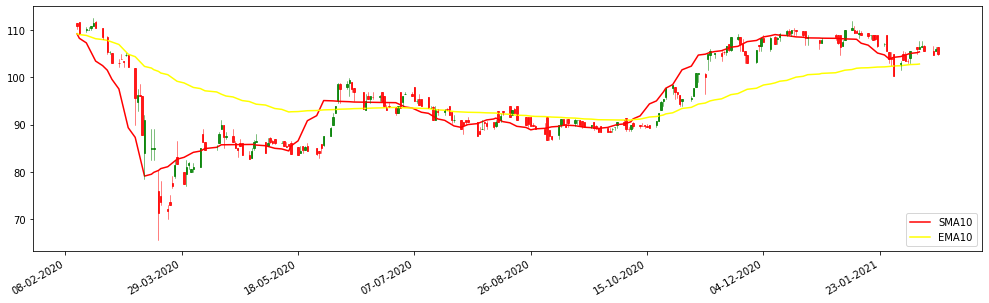

In [60]:
searchAndGetInfo('FMETF', 'Philippines', '13/2/2020', '17/2/2021', 10)

In [55]:
retrieveInformation('ACEN', 'Philippines')

Prev. Close                   7.79
Todays Range           7.66 - 7.84
Revenue                19020000000
Open                          7.84
52 wk Range           1.39 - 11.28
EPS                           0.23
Volume                    16251600
Market Cap            122250000000
Dividend (Yield)       N/A (0.47%)
Average Vol. (3m)         61271051
P/E Ratio                    33.15
Beta                          1.18
1-Year Change              301.57%
Shares Outstanding     15960037644
dtype: object


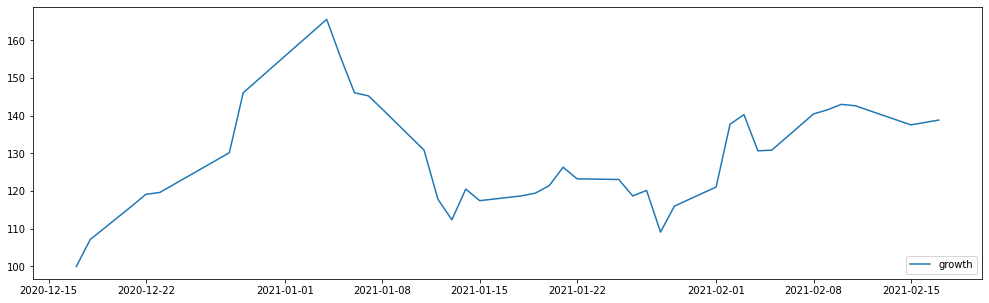

In [25]:
getPercentageGrowth('ACEN', 'Philippines', '17/12/2020', '17/2/2021')

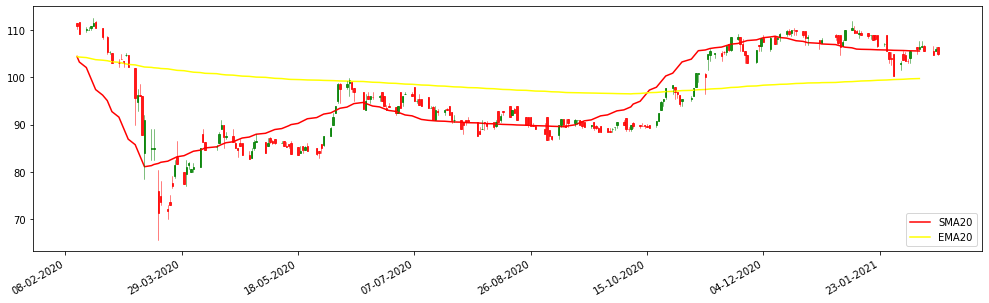

In [6]:
getInfo('FMETF','philippines', '13/2/2020', '17/2/2021', 20)

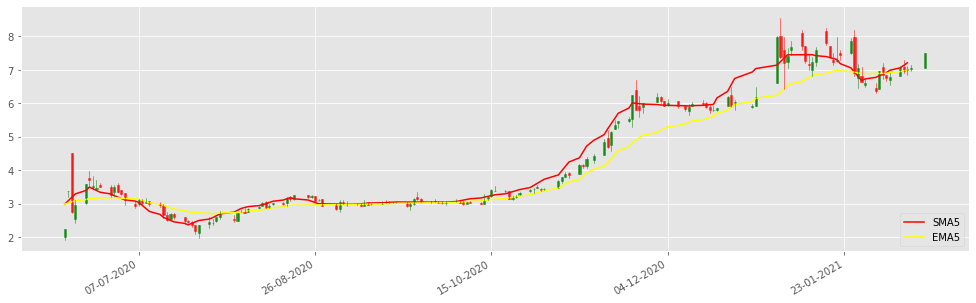

In [81]:
searchAndGetInfo('MM', 'Philippines', '17/2/2020', '17/2/2021', 5)

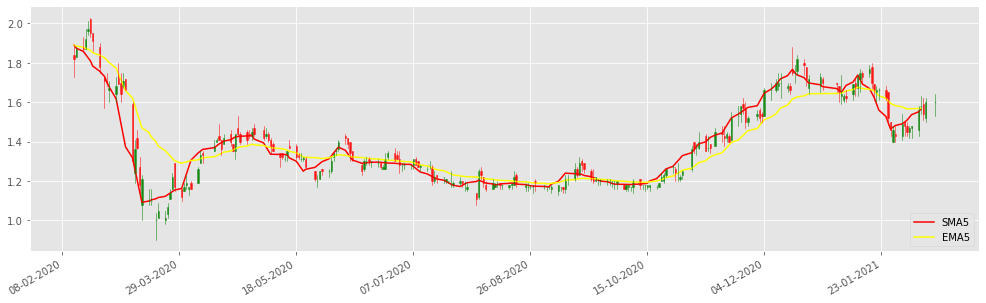

In [82]:
searchAndGetInfo('FRUIT', 'Philippines', '13/2/2020', '15/2/2021', 5)

In [ ]:
##find support and resistance
##try to find a trend
####find when a trend has started and is about to change